# G3 Processing

This file contains code to view and load G3 files produced by ``g3_packager``.

To run this Jupyter notebook on the CCAT Control Computer, see [``HOWTORUN.md``](./HOWTORUN.md).

## G3 File Analysis

In [1]:
import numpy as np
import os
import g3utils as ut
import matplotlib.pyplot as plt
import so3g.proj
from spt3g import core

In [2]:
control_computer_g3_dir = "/media/player1/blast2020fc1/blasttng_g3"
path_to_file = "testing/roach1_pass3.g3"
filename = os.path.join(control_computer_g3_dir, path_to_file)

### File Content Overview

In [3]:
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=filename)
pipe.Add(ut.FrameCounter)
pipe.Run()


Calibration
PipelineInfo
Scan (x117)
EndProcessing


### File Content Full Dump

In [4]:
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=filename)
pipe.Add(core.Dump)
pipe.Run()

Frame (Calibration) [
"target_sweeps" (spt3g.core.G3TimestreamMap) => Timestreams from 1143 detectors
"x_shifts" (spt3g.core.G3MapDouble) => 381 elements
"y_shifts" (spt3g.core.G3MapDouble) => 381 elements
]
Frame (PipelineInfo) [
"09-Apr-2025:00:26:54.280809000" (spt3g.core.G3PipelineInfo) => UNKNOWN VCS branch, local diffs
"09-Apr-2025:00:28:06.237227000" (spt3g.core.G3PipelineInfo) => UNKNOWN VCS branch, local diffs
]
Frame (Scan) [
"alt" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"az" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"data" (so3g.G3SuperTimestream) => G3SuperTimestream(762, 1428)
"el" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"lat" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"lon" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"time" (spt3g.core.G3Time) => 09-Apr-2025:00:26:54.280026000
]
Frame (Scan) [
"alt" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"az" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"

### Scan Frames

In [5]:
first_scan_grabber = ut.FirstFrameGrabber(core.G3FrameType.Scan)
last_scan_grabber = ut.LastFrameGrabber(core.G3FrameType.Scan)

pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=filename)
pipe.Add(first_scan_grabber)
pipe.Add(last_scan_grabber)
pipe.Run()

first_scan_frame = first_scan_grabber.first_frame
last_scan_frame = last_scan_grabber.last_frame

print("\nFirst Scan Frame: ", first_scan_frame)
print("\nLast Scan Frame: ", last_scan_frame)

Found the first frame with type: Scan!
The frame is now stored in <g3utils.FirstFrameGrabber object at 0x7f5557563340>'s first_frame attribute.
Found the last frame with type: Scan!
The frame is now stored in <g3utils.LastFrameGrabber object at 0x7f5557563880>'s last_frame attribute.

First Scan Frame:  Frame (Scan) [
"alt" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"az" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"data" (so3g.G3SuperTimestream) => G3SuperTimestream(762, 1428)
"el" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"lat" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"lon" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"time" (spt3g.core.G3Time) => 09-Apr-2025:00:26:54.280026000
]

Last Scan Frame:  Frame (Scan) [
"alt" (spt3g.core.G3Timestream) => 935 samples at 473.1 Hz
"az" (spt3g.core.G3Timestream) => 935 samples at 473.1 Hz
"data" (so3g.G3SuperTimestream) => G3SuperTimestream(762, 935)
"el" (spt3g.core.G3Timestream) => 935 sam

### Calibration Frame

In [6]:
calframe_grabber = ut.FirstFrameGrabber(core.G3FrameType.Calibration)

pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=filename)
pipe.Add(calframe_grabber)
pipe.Run()

cal_frame = calframe_grabber.first_frame

print("\nCalibration Frame: ", cal_frame)

Found the first frame with type: Calibration!
The frame is now stored in <g3utils.FirstFrameGrabber object at 0x7f55575b4970>'s first_frame attribute.

Calibration Frame:  Frame (Calibration) [
"target_sweeps" (spt3g.core.G3TimestreamMap) => Timestreams from 1143 detectors
"x_shifts" (spt3g.core.G3MapDouble) => 381 elements
"y_shifts" (spt3g.core.G3MapDouble) => 381 elements
]


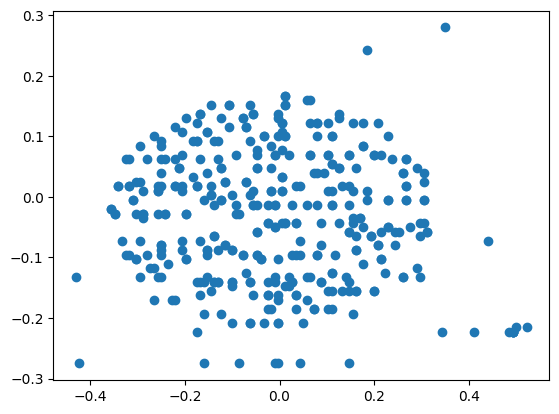

In [7]:
x_vals = np.asarray(cal_frame["x_shifts"].values()) / core.G3Units.deg
y_vals = np.asarray(cal_frame["y_shifts"].values()) / core.G3Units.deg
plt.scatter(x_vals, y_vals)

In [8]:
# Here is how to load targ_sweeps info for DF calculation

If_0000 = np.array(cal_frame["target_sweeps"]["roach1_0000_I"])
Qf_0000 = np.array(cal_frame["target_sweeps"]["roach1_0000_Q"])
Ff_0000 = np.array(cal_frame["target_sweeps"]["roach1_0000_F"])

for name, arr in zip(("If", "Qf", "Ff"), (If_0000, Qf_0000, Ff_0000)):
    print(f"{name}.shape: ", arr.shape)

# If, Qf, and Ff are required inputs to df_IQangle, in addition to the KID I/Q data

If.shape:  (176,)
Qf.shape:  (176,)
Ff.shape:  (176,)


### RA/DEC Computation

We can now compute RA/DEC from the stored information, add "ra" and "dec" as keys in the scan frame, and save the result of the pipeline to a new file.

In [9]:
radec_file = os.path.join(control_computer_g3_dir, "testing/add_radec.g3")

In [10]:
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=filename)
pipe.Add(ut.add_radec)
pipe.Add(core.G3Writer, filename=radec_file)
pipe.Run(profile=True)

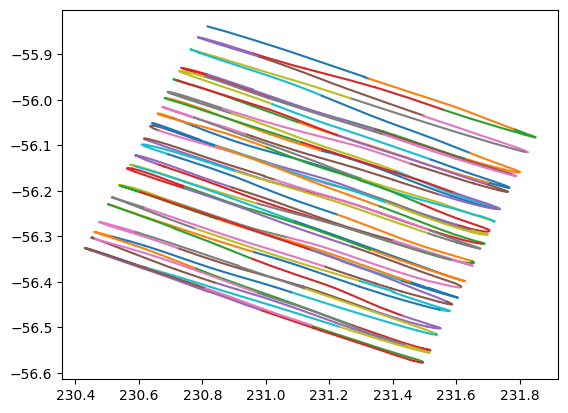

In [11]:
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=radec_file)
pipe.Add(ut.plot_ra_dec)
pipe.Run()

### DF Calculation

#### Single Detector

In [12]:
single_df_file = os.path.join(control_computer_g3_dir, "testing/add_single_df.g3")

In [13]:
pipe = core.G3Pipeline()

pipe.Add(core.G3Reader, filename=radec_file)
pipe.Add(ut.AddSingleKidDF, roach_id=1, kid="0000")
pipe.Add(core.Dump)
pipe.Add(core.G3Writer, filename=single_df_file)

pipe.Run()

Frame (Calibration) [
"target_sweeps" (spt3g.core.G3TimestreamMap) => Timestreams from 1143 detectors
"x_shifts" (spt3g.core.G3MapDouble) => 381 elements
"y_shifts" (spt3g.core.G3MapDouble) => 381 elements
]
Frame (PipelineInfo) [
"09-Apr-2025:00:26:54.280809000" (spt3g.core.G3PipelineInfo) => UNKNOWN VCS branch, local diffs
"09-Apr-2025:00:28:06.954568000" (spt3g.core.G3PipelineInfo) => UNKNOWN VCS branch, local diffs
"09-Apr-2025:00:28:49.580913000" (spt3g.core.G3PipelineInfo) => UNKNOWN VCS branch, local diffs
]
Frame (Scan) [
"alt" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"az" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"data" (so3g.G3SuperTimestream) => G3SuperTimestream(762, 1428)
"dec" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"el" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"lat" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"lon" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"ra" (spt3g.core.G3Timestream) => 1428 sam

In [14]:
scan_frame_grabber = ut.FirstFrameGrabber(core.G3FrameType.Scan)

pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=single_df_file)
pipe.Add(scan_frame_grabber)
pipe.Run()

first_scan_frame = scan_frame_grabber.first_frame

print("\nFirst Scan Frame: ", first_scan_frame)

Found the first frame with type: Scan!
The frame is now stored in <g3utils.FirstFrameGrabber object at 0x7f55514ee170>'s first_frame attribute.

First Scan Frame:  Frame (Scan) [
"alt" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"az" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"data" (so3g.G3SuperTimestream) => G3SuperTimestream(762, 1428)
"dec" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"el" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"lat" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"lon" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"ra" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"roach1_0000_DF" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"time" (spt3g.core.G3Time) => 09-Apr-2025:00:26:54.280026000
]


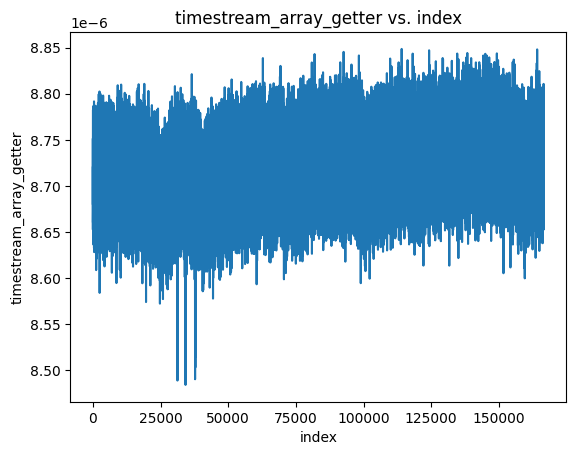

In [15]:
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=single_df_file)
pipe.Add(ut.TimeStreamPlotter, ts_key="roach1_0000_DF")
pipe.Run()

#### All Detectors

In [16]:
all_df_file = os.path.join(control_computer_g3_dir, "testing/add_all_df.g3")

In [17]:
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=radec_file)
pipe.Add(ut.AddAllDF, roach_id=1)
pipe.Add(ut.FrameCounter)
pipe.Add(core.G3Writer, filename=all_df_file)
pipe.Run()


Calibration
PipelineInfo
Scan (x117)
EndProcessing


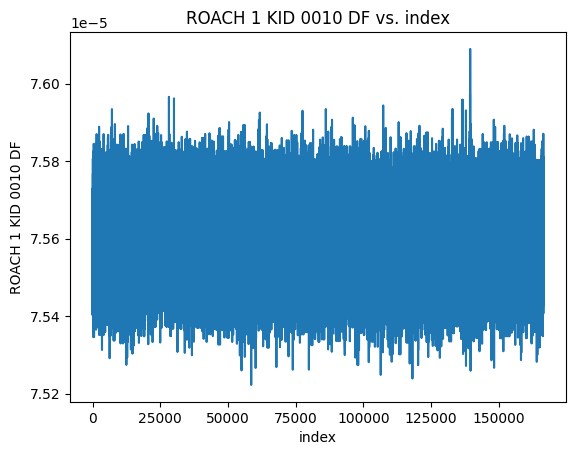

In [18]:
pipe = core.G3Pipeline()

def kid_df_getter(kid: str):
    def get_selected_kid_df(frame):
        kid_key = f"roach1_{kid}"
        super_ts = frame["df"]
        kid_idx = int(np.where(np.array(super_ts.names) == kid_key)[0][0])
        return np.array(super_ts.data[kid_idx])
    return get_selected_kid_df

kid_to_plot = "0010"
pipe.Add(core.G3Reader, filename=all_df_file)
pipe.Add(ut.GenericPlotter, array_getter=kid_df_getter(kid_to_plot), label=f"ROACH 1 KID {kid_to_plot} DF")
pipe.Run()

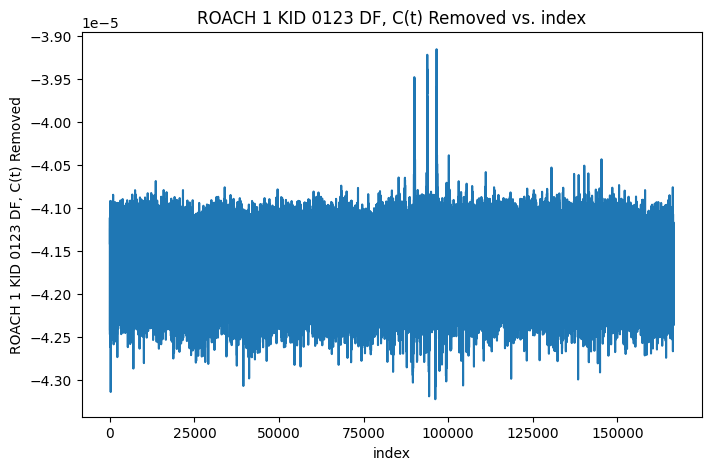

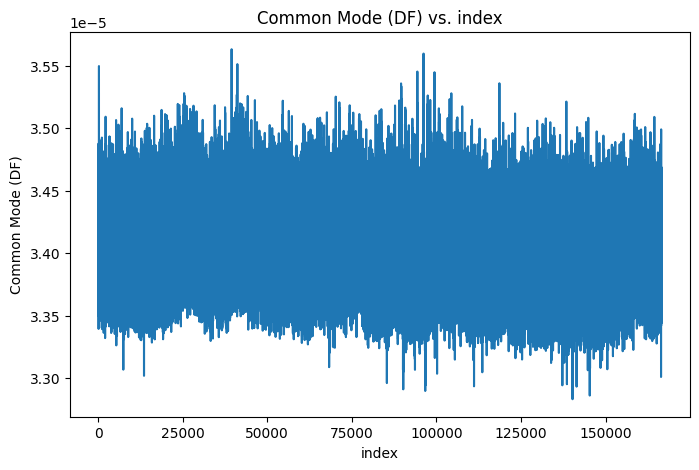

In [19]:
pipe = core.G3Pipeline()

def kid_df_ctremoved_getter(kid: str):
    def get_selected_kid_df(frame):
        kid_key = f"roach1_{kid}"
        super_ts = frame["df_ctremoved"]
        kid_idx = int(np.where(np.array(super_ts.names) == kid_key)[0][0])
        return np.array(super_ts.data[kid_idx])
    return get_selected_kid_df

kid_to_plot = "0123"
pipe.Add(core.G3Reader, filename=all_df_file)
pipe.Add(ut.remove_common_mode)  # naive: non-normalized DF, no weights...
pipe.Add(ut.GenericPlotter,
         array_getter=kid_df_ctremoved_getter(kid_to_plot),
         label=f"ROACH 1 KID {kid_to_plot} DF, C(t) Removed",
         subplots_args={"figsize": (8, 5)})
pipe.Add(ut.TimeStreamPlotter,
         label=f"Common Mode (DF)",
         ts_key="common_mode",
         subplots_args={"figsize": (8, 5)})
pipe.Run()

In [20]:
# center of the sky map
ra0 = 231.15 * core.G3Units.deg
dec0 = -56.2 * core.G3Units.deg

# map dimensions
xlen = 1.4 * core.G3Units.deg
ylen = 0.9 * core.G3Units.deg

# pixel resolution
res = 1.5 * core.G3Units.arcmin

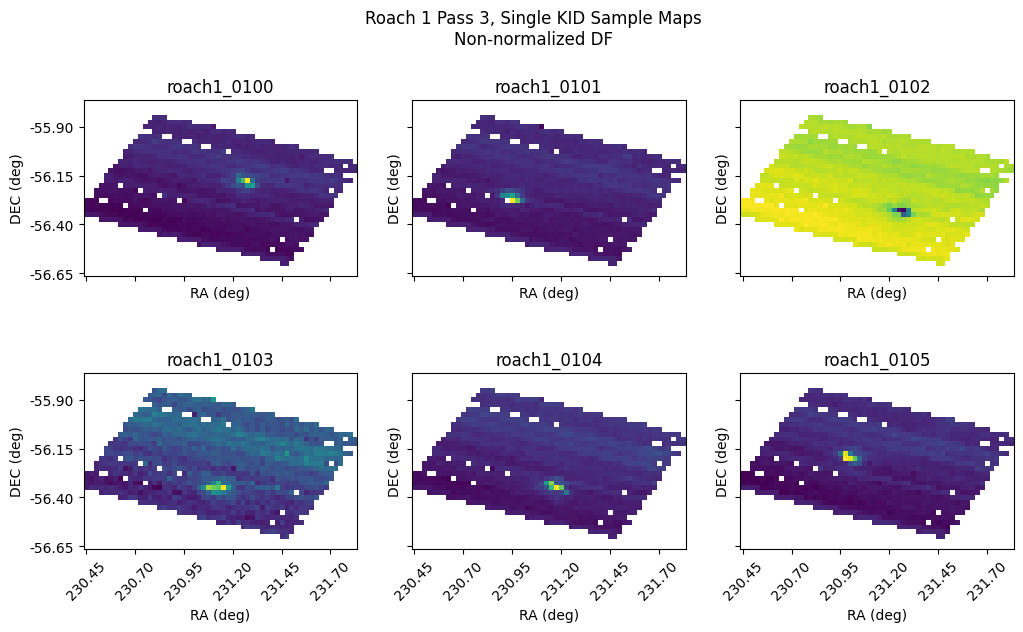

In [21]:
# instantiate binners
binners = [ut.SingleMapBinner(kid=f"roach1_0{i:03}", timestreams="df", ra0=ra0, dec0=dec0, xlen=xlen, ylen=ylen, res=res)
           for i in range(100, 106)]

# create the pipeline
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=all_df_file)
pipe.Add(ut.remove_common_mode)
for binner in binners:
    pipe.Add(binner)
pipe.Run()

fig, axs = plt.subplots(2, 3, figsize=(12, 6.5), sharex='all', sharey='all')
fig.suptitle("Roach 1 Pass 3, Single KID Sample Maps"
            "\nNon-normalized DF")

for binner, ax in zip(binners, axs.flat):
    binner.plot(ax=ax)
plt.show()

In [67]:
rcw_92_min_lat = -77.110
rcw_92_max_lat = -77.070
rcw_92_min_lon = 162.20
rcw_92_max_lon = 162.55
rcw_92_min_alt = 36030
rcw_92_max_alt = 36120
rcw_92_avg_lat = rcw_92_min_lat/2. + rcw_92_max_lat/2.
rcw_92_avg_lon = rcw_92_min_lon/2. + rcw_92_max_lon/2.
rcw_92_avg_alt = rcw_92_min_alt/2. + rcw_92_max_alt/2.
BLASTTNG_SITE = so3g.proj.EarthlySite(rcw_92_avg_lon, rcw_92_avg_lat, rcw_92_avg_alt)  # we could also add weather

class MapBinner:
    def __init__(self, timestreams="df", site=None, ra0=None, dec0=None, xlen=None, ylen=None, res=None):
        # center of the sky map
        assert ra0 is not None, "must set ra0!"
        assert dec0 is not None, "must set dec0!"
        self.site = site if site is not None else BLASTTNG_SITE

        self.ra0 = ra0
        self.dec0 = dec0

        self.xlen = xlen if xlen is not None else 1 * core.G3Units.deg
        self.ylen = ylen if ylen is not None else 1 * core.G3Units.deg

        self.res = res if res is not None else 1 * core.G3Units.arcmin

        # number of bins along each axis
        self.nx = int(self.xlen / self.res)
        self.ny = int(self.ylen / self.res)

        # bin edges
        self.ra_edges = np.linspace(-self.xlen / 2, self.xlen / 2, self.nx + 1) + self.ra0
        self.dec_edges = np.linspace(-self.ylen / 2, self.ylen / 2, self.ny + 1) + self.dec0

        self.timestreams = timestreams

        # array for storing the binned timestream data
        self.data = np.zeros((self.ny, self.nx), dtype=float)

        # array for storing the number of times each pixel is "hit" in the timestreams
        self.hits = np.zeros((self.ny, self.nx), dtype=float)

        self.framect = 0

        self.calframe = None
        self.focalplane = None

    def __call__(self, frame):
        if frame.type == core.G3FrameType.Calibration:
            self.calframe = frame
            self.focalplane = so3g.proj.FocalPlane.from_xieta(
                # TODO: verify that G3MapDouble.values(), which returns a list, has the same ordering as G3MapDouble.keys()
                np.asarray(cal_frame["x_shifts"].values()) / core.G3Units.rad,
                np.asarray(cal_frame["y_shifts"].values()) / core.G3Units.rad
            )
        if self.timestreams not in frame:
            return
        assert self.calframe is not None, "failed to process scan frame: missing prior calibration frame!"

        super_ts = frame[self.timestreams]

        # some KIDs may not be present in layout files
        # because bad KIDs mess up the source shift calculation 
        common_kids: list[str] = list(
            set(super_ts.names)
            .intersection(set(cal_frame["x_shifts"].keys()))
            .intersection(set(cal_frame["y_shifts"].keys()))
        )

        # BLAST-TNG isn't exactly 'Earthly'... but this is the best we can do
        # CCAT won't have this problen
        times = np.array(frame["data"].times) / core.G3Units.s
        csl = so3g.proj.CelestialSightLine.naive_az_el(
            times,
            frame["az"] / core.G3Units.rad,
            frame["el"] / core.G3Units.rad,
            site=self.site
        )
        coords = csl.coords(self.focalplane)

        for kid in common_kids:
            kid_timestream_idx = int(np.where(np.array(super_ts.names) == kid)[0][0])
            kid_ts = super_ts.data[kid_timestream_idx]

            # note: I'm not sure the coordinate conversions are correct
            # further analysis of all coordinate conversions is required
            
            kid_focalplane_idx = int(np.where(np.array(cal_frame["x_shifts"].keys()) == kid)[0][0])
            kid_coords = coords[kid_focalplane_idx]
            x = np.mod(kid_coords[:, 0], 2*np.pi) * core.G3Units.rad
            y = kid_coords[:, 1] * core.G3Units.rad

            if kid == "roach1_0000":
                print(np.mean(x)/core.G3Units.deg, np.mean(y)/core.G3Units.deg)
            
            # update data and hits, in-place
            self.data += np.histogram2d(y, x, bins=[self.dec_edges, self.ra_edges], weights=kid_ts)[0]
            self.hits += np.histogram2d(y, x, bins=[self.dec_edges, self.ra_edges])[0]
        
        self.framect += 1
        # print(f"MapBinner: Processed Frame {self.framect}")

    def plot(self, ax=None):
        with np.errstate(invalid='ignore'):
            m = self.data / self.hits
        if ax is not None:
            ax.imshow(m, origin='lower')
            ax.set_xticks(range(self.nx+1)[::10], [f"{ra:.2f}" for ra in self.ra_edges[::10] / core.G3Units.deg], rotation=45)
            ax.set_yticks(range(self.ny+1)[::10], [f"{dec:.2f}" for dec in self.dec_edges[::10] / core.G3Units.deg])
            ax.set_xlabel("RA (deg)")
            ax.set_ylabel("DEC (deg)")
            ax.set_title("Combined Map")
        else:
            plt.imshow(m, origin='lower')
            plt.xticks(range(self.nx+1)[::10], [f"{ra:.2f}" for ra in self.ra_edges[::10] / core.G3Units.deg], rotation=45)
            plt.yticks(range(self.ny+1)[::10], [f"{dec:.2f}" for dec in self.dec_edges[::10] / core.G3Units.deg])
            plt.colorbar(label="DF")
            plt.xlabel("RA (deg)")
            plt.ylabel("DEC (deg)")
            plt.title("Combined Map")
            plt.show()


231.30597037134723 -56.09927059535175
231.8109731438709 -56.21542960774991
232.02063703384025 -56.27257145066291
231.4997959152656 -56.16309864984276
231.10530109286165 -56.0853136904401
231.5007301327089 -56.180807096024765
231.96026205636588 -56.29127975617996
231.82748167547558 -56.270458096076794
231.24646560157507 -56.14499277236361
231.1806649854516 -56.135637971854635
231.67849434149772 -56.26400280962065
232.0032296262118 -56.35357212727064
231.57623099512818 -56.26747467033038
231.0809098547305 -56.15740020578324
231.34351207555747 -56.21428029921505
231.84214771471227 -56.32590166075921
231.90968919238097 -56.34430586729987
231.34247571305252 -56.21849608886991
231.08409108203927 -56.16653116688562
231.5507447012842 -56.281394019044434
231.96338702913832 -56.38161325746041
231.67393432629262 -56.325159628522826
231.12313630173242 -56.196814268772386
231.23858673847297 -56.2210699047623
231.7457245249034 -56.34146963234626
231.95254220339666 -56.392673925210374
231.42371988658

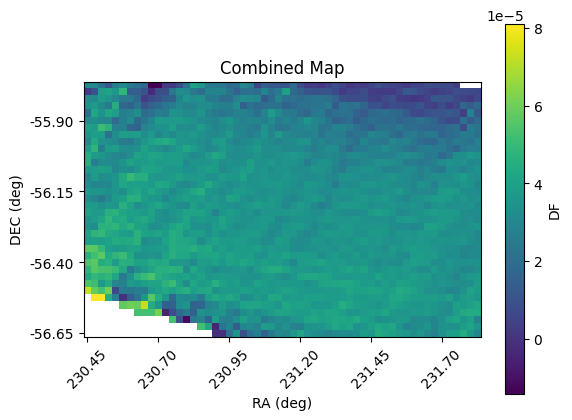

In [68]:
# instantiate binners
binner = MapBinner(timestreams="df", ra0=ra0, dec0=dec0, xlen=xlen, ylen=ylen, res=res)

# create the pipeline
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=all_df_file)
# pipe.Add(ut.remove_common_mode)
pipe.Add(binner)
pipe.Run()

binner.plot()

In [65]:
class AddRaDec:
    def __init__(self, site=None):
        self.site = site if site is not None else BLASTTNG_SITE

    def __call__(self, frame):
        if frame.type != core.G3FrameType.Scan:
            return
        times = np.array(frame["data"].times) / core.G3Units.s
        csl = so3g.proj.CelestialSightLine.naive_az_el(
            times,
            frame["az"] / core.G3Units.rad,
            frame["el"] / core.G3Units.rad,
            site=self.site
        )
        coords = csl.coords(so3g.proj.FocalPlane.boresight())
        x = np.mod(coords[0][:, 0], 2*np.pi) * core.G3Units.rad
        y = coords[0][:, 1] * core.G3Units.rad
        frame["csl_ra"] = core.G3VectorDouble(x)
        frame["csl_dec"] = core.G3VectorDouble(y)

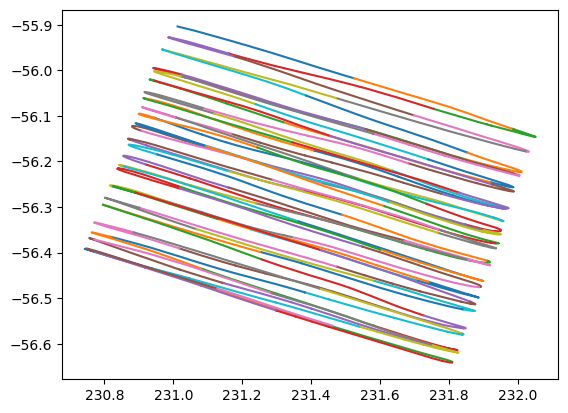

In [66]:
pipe = core.G3Pipeline()

pipe.Add(core.G3Reader, filename=filename)
pipe.Add(AddRaDec, site=BLASTTNG_SITE)
pipe.Add(ut.plot_ra_dec, ra_key="csl_ra", dec_key="csl_dec")

pipe.Run()

In [54]:
csl = so3g.proj.CelestialSightLine.naive_az_el(
    first_scan_frame["time"].time / core.G3Units.s,
    first_scan_frame["az"] / core.G3Units.rad,
    first_scan_frame["el"] / core.G3Units.rad,
    site=BLASTTNG_SITE
)
focalplane = so3g.proj.FocalPlane.from_xieta(
    np.asarray(cal_frame["x_shifts"].values()) / core.G3Units.rad,
    np.asarray(cal_frame["y_shifts"].values()) / core.G3Units.rad
)
bs_focalplane = so3g.proj.FocalPlane.boresight()
coords = csl.coords(bs_focalplane)

coords[0][:, 0]

array([1.73020848, 1.73021404, 1.73021802, ..., 1.73891097, 1.73892069,
       1.73892069], shape=(1428,))

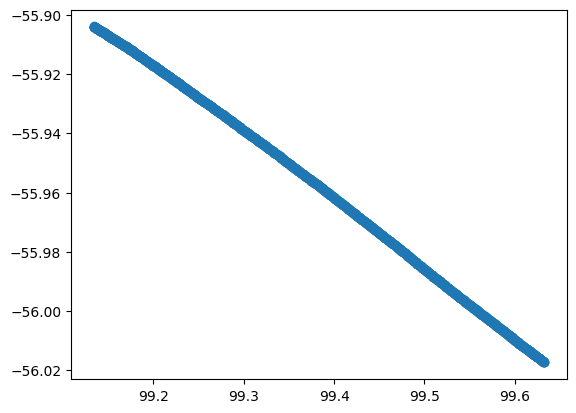

In [50]:
kid_idx = 0
plt.scatter(coords[kid_idx][:, 0] * 180/np.pi, coords[kid_idx][:, 1] * 180/np.pi)